In [680]:
import numpy as np
import cv2
from cv2 import aruco
import pandas as pd
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick 


In [681]:
# 軌跡データ
# csv_path = "output/test/markers_t_hd_60.csv"  # フィルタ適用前
# csv_path = "output/test/markers_t_h_60_comlement_filter_bltrl_hybrid_2.csv" # フィルタ適用後+スプライン補完
# csv_path = "output/test/markers_t_h_60_liner_comlement_filter_bltrl_hybrid.csv" # フィルタ適用後+線形補完
csv_path = "output/test/markers_carton_g_hd_60_liner_filter.csv"
# csv_path = "output/test/markers_base_4k_60_liner_filter.csv"
markers_raw = pd.read_csv(csv_path, header=[0, 1])
frames = len(markers_raw)

# 外れ値とする最小四分位数
q_min = 0.10

# 外れ値とする最大四分位数
q_max = 0.90

# 解析で使用するidのデータだけ抜き出し
ids = list(map(lambda col: str(col), [4,5,6,7]))
markers = markers_raw[ids]

# 構造（線の接続関係）の定義
# stractures = [[0,1,2,3,0],[4,5,6,7,4]]

In [682]:
# 異常値の取り除き
def outlier_iqr(df, q_min=0.25, q_max=0.75):

    for i in range(len(df.columns)):

        # 列を抽出する
        col = df.iloc[:,i]

        # 分位数
        val_q_min = col.quantile(q_min)
        val_q_max = col.quantile(q_max)
        iqr = val_q_max - val_q_min #分位範囲

        # 外れ値の基準点
        outlier_min = val_q_min - (iqr)
        outlier_max = val_q_max + (iqr)

        # 範囲から外れている値を除く
        col[col < outlier_min] = None
        col[col > outlier_max] = None

    return df

In [683]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [684]:
id = ids[1]
# 小数点以下 桁数 6
pd.options.display.float_format = '{:.6f}'.format

orbit = markers[[(str(id), 'x'),(str(id), 'y'),(str(id), 'z')]]
orbit.columns = orbit.columns.droplevel(0)

print("raw data")
orbit.describe()

raw data


,x,y,z
count,3627.000000,3627.000000,3627.000000
mean,1.228362,-0.172953,1.642450
std,0.932202,0.133733,1.244827
min,1.141701,-6.614201,1.525074
25%,1.193708,-0.174912,1.596979
50%,1.202505,-0.169330,1.607576
75%,1.212621,-0.163663,1.621181
max,46.210872,-0.140082,61.710998


In [685]:
orbit = outlier_iqr(orbit, q_min, q_max)  # 外れ値の除去
orbit = mean_norm(orbit)

print("standardized data")
orbit.describe()

standardized data


,x,y,z
count,3606.000000,3624.000000,3607.000000
mean,0.000000,-0.000000,0.000000
std,1.000000,1.000000,1.000000
min,-3.622274,-3.370862,-3.567125
25%,-0.631020,-0.658619,-0.598538
50%,-0.050204,0.008144,-0.069620
75%,0.621355,0.687756,0.609270
max,3.781783,3.502238,3.783827


(0, 0) 4
(0, 1) 5
(1, 1) 6
(1, 0) 7


Text(0.5, 0.98, 'sample 1: x-y coordinates')

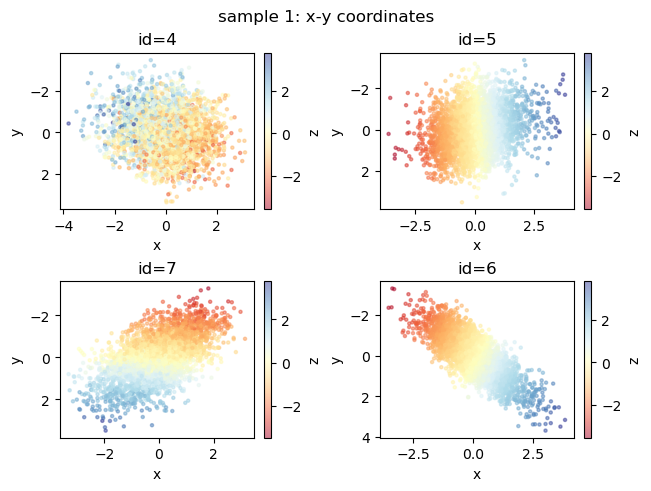

In [686]:
x, y = [2,2]
fig, axs = plt.subplots(y, x, constrained_layout=True)

cm = plt.cm.get_cmap('RdYlBu') # プロットのカラーマップ
for g, id in zip([(0, 0),(0, 1),(1, 1),(1, 0),], ids):
    print(g, id)
    orbit = markers[[(str(id), 'x'),(str(id), 'y'),(str(id), 'z')]]
    orbit.columns = orbit.columns.droplevel(0)
    orbit = outlier_iqr(orbit, q_min, q_max)  # 外れ値の除去
    orbit = mean_norm(orbit)
    # print(orbit.describe())
    mappable = axs[g].scatter(orbit['x'], orbit['y'], c=list(orbit['z']),cmap=cm,s=5, alpha=0.5)
    fig.colorbar(mappable, ax=axs[g], label="z")
    axs[g].invert_yaxis()   # y座標反転（左上が原点）
    axs[g].set_title(f"id={id}")
    axs[g].set_xlabel("x")
    axs[g].set_ylabel("y")

fig.suptitle("sample 1: x-y coordinates")


In [687]:
orbit.to_csv("output/xyz.csv")